In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xgboost as xg
from tqdm import tqdm
import glob
import seaborn as sns
import cv2
import io
from PIL import Image
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import ipywidgets as widgets
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def load_imgs(path):
    folders=os.listdir(path)
    data = []
    age=[]
    gender = []
    ethnicity =[]
#     folders.remove('dataset')
    for i in tqdm(folders):
            im=Image.open(path+'/'+i).convert('RGB')
            im=im.resize((48,48))
            ar=np.array(im)
            data.append(ar)
            age.append(int(i.split('_')[0]))
            gender.append(int(i.split('_')[1]))
            ethnicity.append(int(i.split('_')[-2]))
#     t=pd.factorize(np.array(label))
   # print(t)
#     tgt=t[0]
    return np.array(data),np.array(age),np.array(gender),np.array(ethnicity)

In [3]:
gender=[ 'male', 'female']
ethnicity = ['white', 'black', 'asian', 'indian', 'other']

In [4]:
x,y_age,y_gender,y_ethnicity = load_imgs('/kaggle/input/utkface-new/UTKFace')

100%|██████████| 23708/23708 [02:52<00:00, 137.07it/s]


In [5]:
# Assuming x, y_gender, y_ethnicity, and y_age are your features and labels
x_train, x_test, y_train_gender, y_test_gender, y_train_ethnicity, y_test_ethnicity, y_train_age, y_test_age = train_test_split(
    x, y_gender, y_ethnicity, y_age,
    test_size=0.1,
    random_state=100
)


# Hyper parameters

In [84]:
learning_rate = 0.0001
batch_size = 256
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 16
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data Augmentation

In [85]:
data_augmentation = keras.Sequential(
    [
#         layers.Input(shape=(image_size, image_size, num_channels)), 
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

(-0.5, 47.5, 47.5, -0.5)

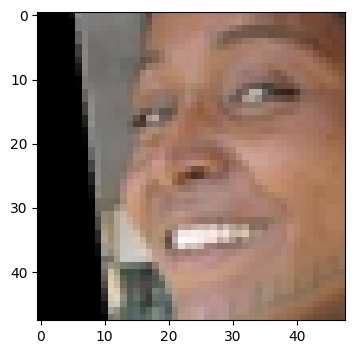

In [86]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("ON")

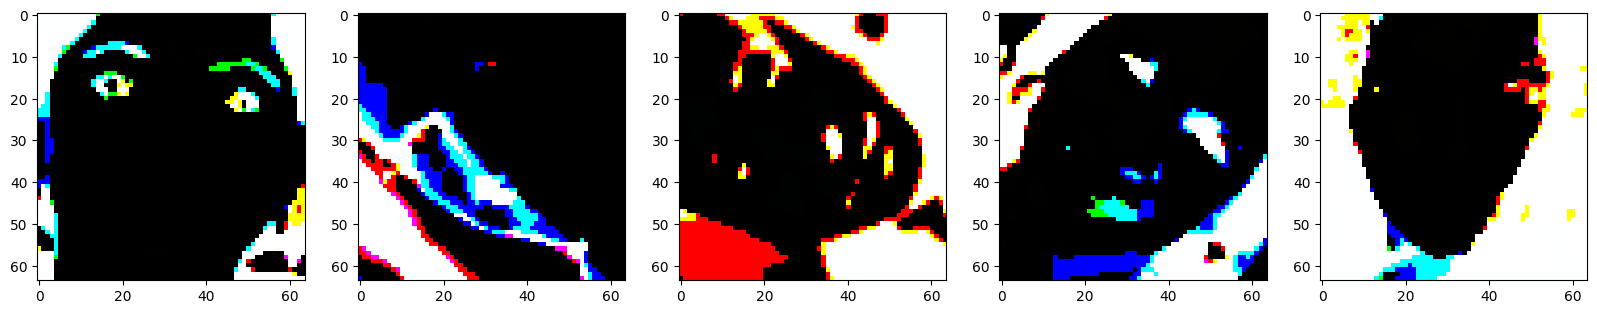

In [87]:
# Generate augmented images
augmented_images = data_augmentation(x_train)

# Plot a few augmented images
num_images = 5
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(num_images):
    axes[i].imshow(augmented_images[i*10].numpy().astype("uint8"))
plt.show()

## building mlp layer

In [88]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)""
        x = layers.Dense(units)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.3)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch Maker

In [89]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


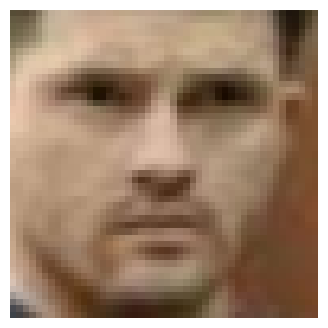

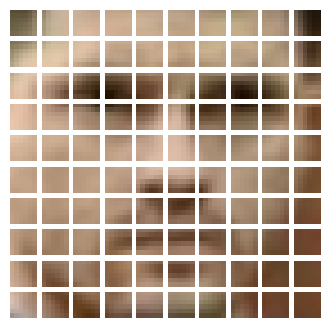

In [90]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Patch Encoder

In [91]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Building Vision Transformer

In [92]:
input_shape = (48,48,3)
num_ethnicities = 5

### Building Vision Transformer

In [93]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dense(256, activation='relu')(representation)
    representation = layers.Dropout(0.1)(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    
    # Age prediction branch
    age_branch = layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
    age_branch = layers.BatchNormalization()(age_branch)
    age_branch = layers.Dropout(0.1)(age_branch)
    age_output = layers.Dense(1,activation = 'linear', name='age_output')(age_branch)  # Assuming age is a regression task

    # Gender prediction branch
    gender_branch = tf.keras.layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
    gender_branch = tf.keras.layers.BatchNormalization()(gender_branch)
    gender_branch = tf.keras.layers.Dropout(0.05)(gender_branch)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

    # Ethnicity prediction branch
    ethnicity_branch = tf.keras.layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
    ethnicity_branch = tf.keras.layers.BatchNormalization()(ethnicity_branch)
    ethnicity_branch = tf.keras.layers.Dropout(0.05)(ethnicity_branch)
    ethnicity_output = layers.Dense(num_ethnicities, activation='softmax', name='ethnicity_output')(ethnicity_branch)

    # Create the Keras model with multiple outputs
    model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])
    return model

### Compiling Model

In [94]:
class MultiTaskEstimator:
    _estimator_type = ''
    classes_ = {'age': None, 'gender': None, 'ethnicity': None}

    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'multi-task classifier'
        self.classes_['age'] = age_classes
        self.classes_['gender'] = gender_classes
        self.classes_['ethnicity'] = ethnicity_classes

    def predict(self, X):
        # Assuming your model returns a list of predictions for each output branch
        predictions = self.model.predict(X)

        # Apply threshold for binary classification (e.g., gender prediction)
        gender_threshold = 0.5
        gender_pred = (predictions[1] > gender_threshold).astype(int)

        # For age prediction, keep it as is
        age_pred = predictions[0]

        # For ethnicity prediction, find the class with the highest probability
        ethnicity_pred = predictions[2].argmax(axis=1)

        return age_pred, gender_pred, ethnicity_pred


In [95]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def run_multi_task_experiment(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss={
            'age_output': keras.losses.MeanSquaredError(),
            'gender_output': keras.losses.BinaryCrossentropy(),
            'ethnicity_output': keras.losses.SparseCategoricalCrossentropy(),
        },
        metrics={
            'age_output': 'mae',
            'gender_output': 'accuracy',
            'ethnicity_output': 'accuracy',
        },
    )

    checkpoint_filepath = "/kaggle/working/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_gender_output_accuracy",  # Monitoring the gender accuracy for saving the best model
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y={'age_output': y_train_age, 'gender_output': y_train_gender, 'ethnicity_output': y_train_ethnicity},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )
    model.save('./model.h5')
    model.load_weights('./model.h5')
    
    # Evaluate the model on the test set
    evaluation = model.evaluate(x_test, {'age_output': y_test_age, 'gender_output': y_test_gender, 'ethnicity_output': y_test_ethnicity})
    
    print(f"Test age MAE: {evaluation[1]}")
    print(f"Test gender accuracy: {evaluation[5]}")
    print(f"Test ethnicity accuracy: {evaluation[6]}")
    
    # Predictions for each task
    y_pred_age, y_pred_gender, y_pred_ethnicity = model.predict(x_test)
    y_pred_gender = np.round(y_pred_gender)
    y_pred_ethnicity= np.argmax(y_pred_ethnicity, axis=1)
    
    # Additional evaluation metrics
    precision_gender = precision_score(y_test_gender, y_pred_gender)
    recall_gender = recall_score(y_test_gender, y_pred_gender)
    f1_gender = f1_score(y_test_gender, y_pred_gender)
    print("Gender Precision:", precision_gender)
    print("Gender Recall:", recall_gender)
    print("Gender F1 Score:", f1_gender)
    
    # Precision, Recall, and F1 for Ethnicity
    precision = precision_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    recall = recall_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    f1 = f1_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    print("Ethnicity Precision:", precision)
    print("Ethnicity Recall:", recall)
    print("Ethnicity F1 Score:", f1)
    # Assuming y_true and y_pred are your true and predicted regression values
    mae = mean_absolute_error(y_test_age, y_pred_age)
    mse = mean_squared_error(y_test_age, y_pred_age)
    r2 = r2_score(y_test_age, y_pred_age)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    return history


In [96]:
vit_classifier = create_vit_classifier()

In [97]:
print(vit_classifier.summary())


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 64, 64, 3)   7           ['input_6[0][0]']                
                                                                                                  
 patches_9 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_5 (PatchEncoder)  (None, 100, 16)     3344        ['patches_9[0][0]']              
                                                                                            

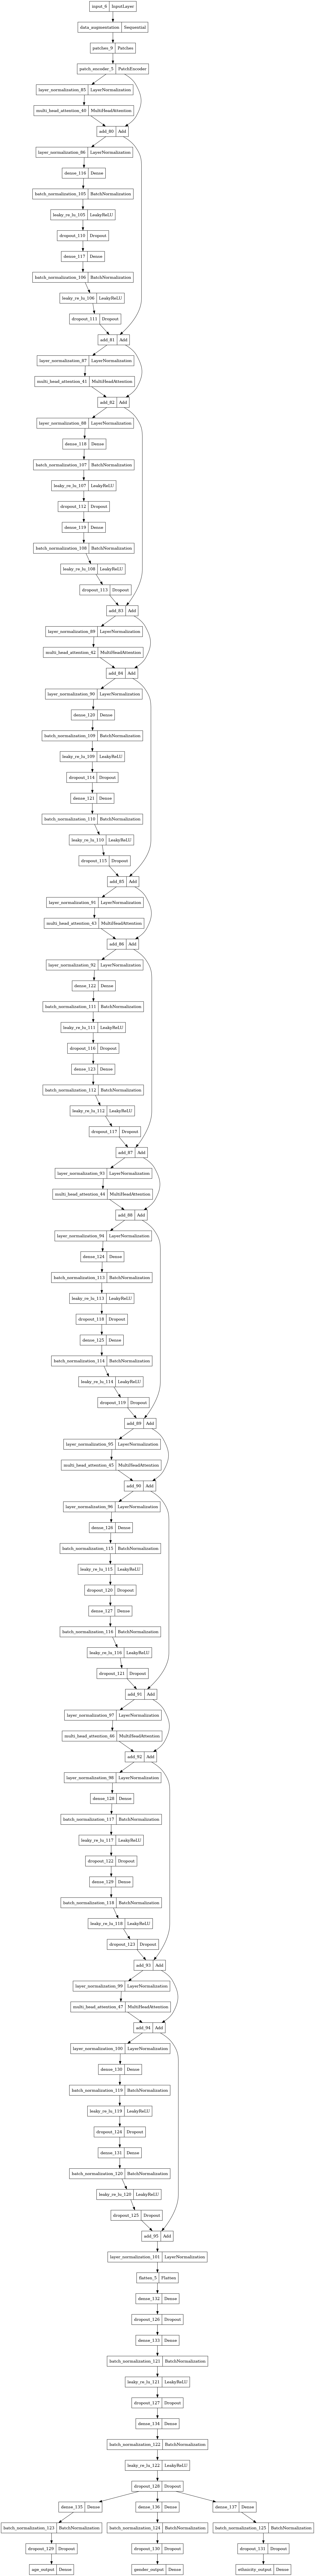

In [98]:
from keras.utils.vis_utils import plot_model
plot_model(vit_classifier, to_file='model.png')

In [99]:
history = run_multi_task_experiment(vit_classifier)

Epoch 1/100
67/67 [==============================] - 51s 159ms/step - loss: 1460.2208 - age_output_loss: 1457.6202 - gender_output_loss: 0.7307 - ethnicity_output_loss: 1.8705 - age_output_mae: 33.2799 - gender_output_accuracy: 0.5997 - ethnicity_output_accuracy: 0.3042 - val_loss: 1563.3737 - val_age_output_loss: 1561.3181 - val_gender_output_loss: 0.6307 - val_ethnicity_output_loss: 1.4250 - val_age_output_mae: 34.5854 - val_gender_output_accuracy: 0.6514 - val_ethnicity_output_accuracy: 0.4541
Epoch 2/100
67/67 [==============================] - 9s 132ms/step - loss: 1421.3378 - age_output_loss: 1419.0525 - gender_output_loss: 0.6536 - ethnicity_output_loss: 1.6321 - age_output_mae: 33.1992 - gender_output_accuracy: 0.6536 - ethnicity_output_accuracy: 0.3617 - val_loss: 1565.9231 - val_age_output_loss: 1563.9030 - val_gender_output_loss: 0.6022 - val_ethnicity_output_loss: 1.4178 - val_age_output_mae: 35.1065 - val_gender_output_accuracy: 0.6731 - val_ethnicity_output_accuracy: 0.45

## Accuracy Plots

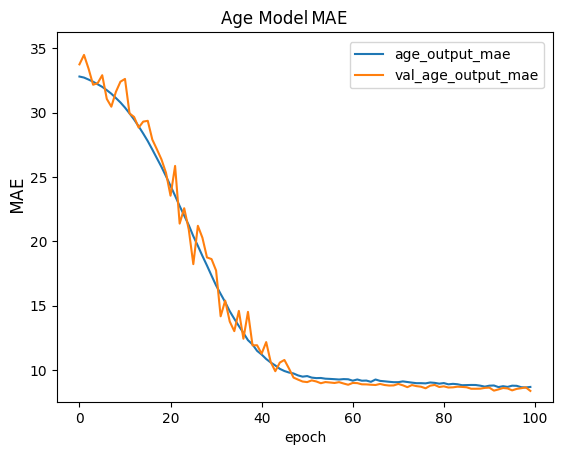

In [100]:
# Age Accuracy Plot
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.legend(['age_output_mae', 'val_age_output_mae'], loc='upper right')
plt.title('Age Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

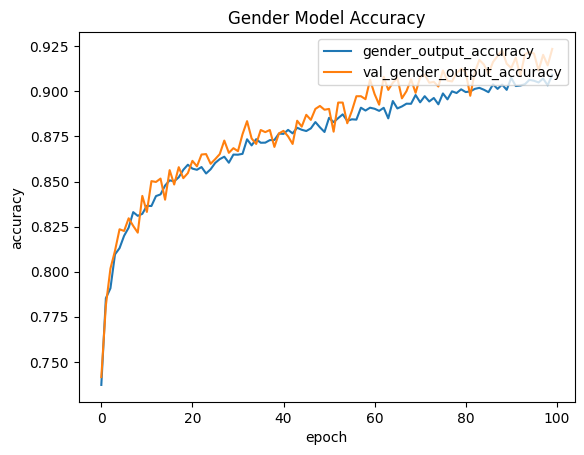

In [101]:
# Gender Accuracy Plot
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['gender_output_accuracy', 'val_gender_output_accuracy'], loc='upper right')
plt.show()

Text(0.5, 0, 'epoch')

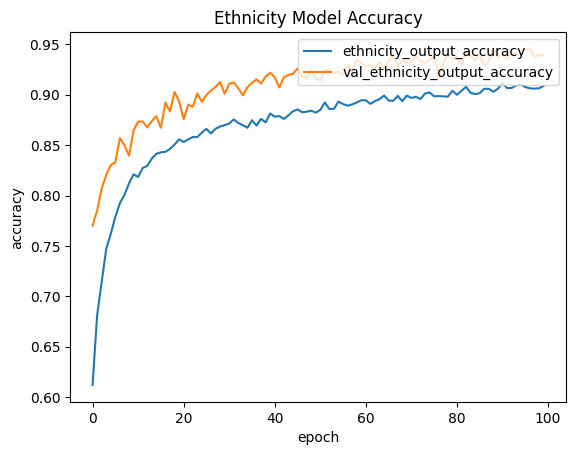

In [102]:
# Ethnicity Accuracy Plot
plt.plot(history.history['ethnicity_output_accuracy'])
plt.plot(history.history['val_ethnicity_output_accuracy'])
plt.legend(['ethnicity_output_accuracy', 'val_ethnicity_output_accuracy'], loc='upper right')
plt.title('Ethnicity Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

## Loss Plots

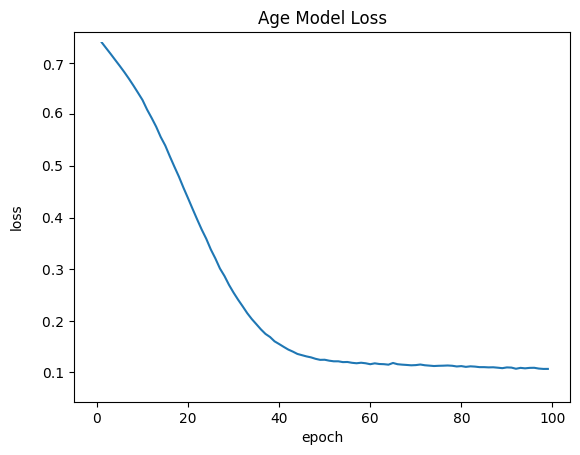

In [103]:
# Age Loss Plot
plt.plot(history.history['age_output_loss'])
plt.title('Age Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

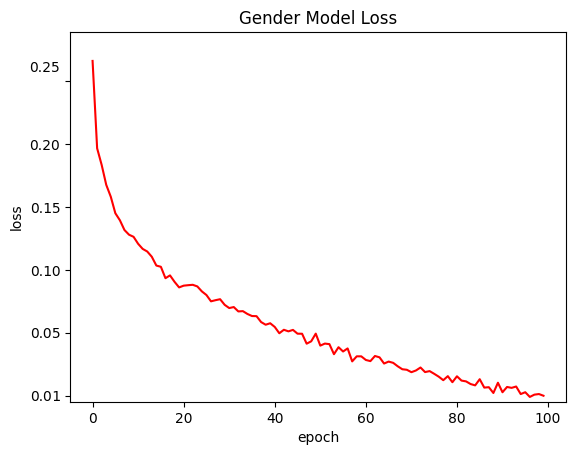

In [104]:
# Gender Loss Plot
plt.plot(history.history['gender_output_loss'], color="r")
plt.title('Gender Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

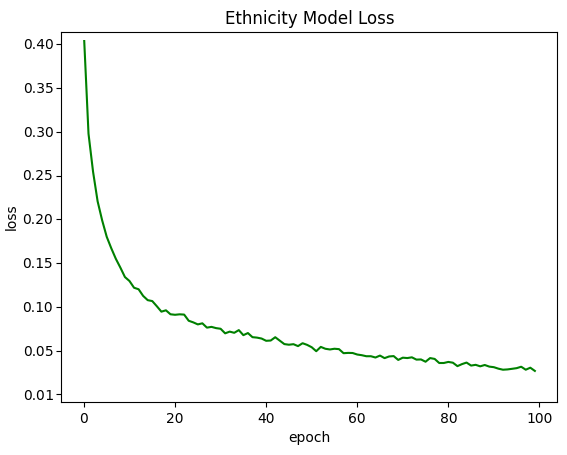

In [105]:
# Ethnicity Loss Plot
plt.plot(history.history['ethnicity_output_loss'], color="g")
plt.title('Ethnicity Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()